# Transforming Transportation: NYC Taxi Demand Prediction with ML

## Data Information

#### Data : https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page (2015 & 2016)

#### Information on Taxis:

<h4>Yellow Taxi: Yellow Medallion Taxicabs: </h4>
These are the famous NYC yellow taxis that provide transportation exclusively through street-hails. The number of taxicabs is limited by a finite number of medallions issued by the TLC. You access this mode of tranansportation by standing in the street and hailing an available taxi with your hand. The pickups are not pre-arranged.

- In the given notebook we are considering only the yellow taxis for the time period Jan 2015 & Jan 2016

In [1]:
!pip install gpxpy
!pip install dask

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.1 MB/s eta 0:00:00


In [2]:
import dask.dataframe as dd
import folium
import math
import scipy
import gpxpy

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import sklearn

import datetime #Convert to unix time
import time #Convert to unix time

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
df = '/content/drive/My Drive/yellow_tripdata_2015-01.csv'

In [29]:
# dask dataframe  : # https://github.com/dask/dask-tutorial/blob/master/07_dataframe.ipynb
df = dd.read_csv(df)

print(df.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


In [9]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


### Features in the Dataset

| **Field Name**             | **Description**                                                                                                                                                  |
|-----------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Dropoff_longitude**       | Longitude where the meter was disengaged.                                                                                                                       |
| **Dropoff_latitude**        | Latitude where the meter was disengaged.                                                                                                                        |
| **Payment_type**            | A numeric code signifying how the passenger paid for the trip:                                                                                                  |
|                             | 1. Credit card                                                                                                                                                  |
|                             | 2. Cash                                                                                                                                                         |
|                             | 3. No charge                                                                                                                                                    |
|                             | 4. Dispute                                                                                                                                                      |
|                             | 5. Unknown                                                                                                                                                      |
|                             | 6. Voided trip                                                                                                                                                  |
| **Fare_amount**             | The time-and-distance fare calculated by the meter.                                                                                                             |
| **Extra**                   | Miscellaneous extras and surcharges, including the $0.50 and $1 rush hour and overnight charges.                                                                |
| **MTA_tax**                 | $0.50 MTA tax that is automatically triggered based on the metered rate in use.                                                                                  |
| **Improvement_surcharge**   | $0.30 improvement surcharge assessed at the flag drop. This surcharge began in 2015.                                                                            |
| **Tip_amount**              | Tip amount. This field is automatically populated for credit card tips. Cash tips are not included.                                                             |
| **Tolls_amount**            | Total amount of all tolls paid during the trip.                                                                                                                 |
| **Total_amount**            | The total amount charged to passengers. Does not include cash tips.                                                                                             |
| **VendorID**                | A code indicating the TPEP provider that provided the record:                                                                                                   |
|                             | - Creative Mobile Technologies                                                                                                                                 |
|                             | - VeriFone Inc.                                                                                                                                                 |
| **tpep_pickup_datetime**    | The date and time when the meter was engaged.                                                                                                                   |
| **tpep_dropoff_datetime**   | The date and time when the meter was disengaged.                                                                                                                |
| **Passenger_count**         | The number of passengers in the vehicle (driver-entered value).                                                                                                 |
| **Trip_distance**           | The elapsed trip distance in miles reported by the taximeter.                                                                                                   |
| **Pickup_longitude**        | Longitude where the meter was engaged.                                                                                                                          |
| **Pickup_latitude**         | Latitude where the meter was engaged.                                                                                                                           |
| **RateCodeID**              | The final rate code in effect at the end of the trip:                                                                                                           |
|                             | 1. Standard rate                                                                                                                                               |
|                             | 2. JFK                                                                                                                                                         |
|                             | 3. Newark                                                                                                                                                      |
|                             | 4. Nassau or Westchester                                                                                                                                       |
|                             | 5. Negotiated fare                                                                                                                                             |
|                             | 6. Group ride                                                                                                                                                  |
| **Store_and_fwd_flag**      | Indicates whether the trip record was held in vehicle memory before sending to the vendor due to no server connection:                                           |
|                             | - Y = Store and forward trip                                                                                                                                    |
|                             | - N = Not a store and forward trip                                                                                                                              |

## ML Problem Formulation

<p><b> Time-series forecasting and Regression</b></p>
-<i> To find number of pickups, given location cordinates(latitude and longitude) and time, in the query reigion and surrounding regions.</i>
<p>
To solve the above we would be using data collected in Jan 2015 to predict the pickups in Jan 2016.
</p>

## Performance metrics
1. Mean Absolute percentage error.
2. Mean Squared error.

## Data Cleaning

-
In this section we will be doing univariate analysis and removing outlier/illegitimate values which may be caused due to some error

### 1. Pickup Latitude and Pickup Longitude

It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with pickups which originate within New York.

In [10]:
# Identify outlier locations (coordinates outside NYC bounding box)
# Filtering rows where coordinates are outside the bounding box
outlier_locations = df[
    (df.pickup_longitude < -74.2591) | (df.pickup_longitude > -73.7004) |
    (df.pickup_latitude < 40.4774) | (df.pickup_latitude > 40.9176)
]

# Create a base map centered around NYC
# read more about the folium here: https://python-visualization.github.io/folium/latest/getting_started.html
map_osm = folium.Map(location=[40.734695, -73.990372])

# we will spot only first 5000 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(5000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)

map_osm

- Observation:- As you can see above that there are some points just outside the boundary but there are a few that are in either South america, Mexico or Canada

In [11]:
map_osm.save("nyc_outliers_map_pickup.html")

### 2. Dropoff Latitude & Dropoff Longitude

In [12]:
outlier_locations = df[
    (df.dropoff_longitude < -74.2591) | (df.dropoff_longitude > -73.7004) |
    (df.dropoff_latitude < 40.4774) | (df.dropoff_latitude > 40.9176)
]

map_osm = folium.Map(location=[40.734695, -73.990372])

# we will spot only first 5000 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(5000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)

map_osm

In [13]:
map_osm.save("nyc_outliers_map_dropoff.html")

- Observation:- The observations here are similar to those obtained while analysing pickup latitude and longitude

### 3. Trip Durations

According to NYC Taxi & Limousine Commision Regulations the maximum allowed trip duration in a 24 hour interval is 12 hours.

In [30]:
# The timestamps are converted to unix so as to get duration(trip-time) & speed also pickup-times in unix are used while binning
# in our data we have time in the formate "YYYY-MM-DD HH:MM:SS" we convert this string to python time format and then into unix time stamp
# https://stackoverflow.com/a/27914405

def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())

# we return a data frame which contains the columns
# 1.'passenger_count' : self explanatory
# 2.'trip_distance' : self explanatory
# 3.'pickup_longitude' : self explanatory
# 4.'pickup_latitude' : self explanatory
# 5.'dropoff_longitude' : self explanatory
# 6.'dropoff_latitude' : self explanatory
# 7.'total_amount' : total fair that was paid
# 8.'trip_times' : duration of each trip
# 9.'pickup_times : pickup time converted into unix time
# 10.'Speed' : velocity of each trip

def return_with_trip_times(df):
    duration = df[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    # pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    # calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    # append durations of trips and speed in miles/hr to a new dataframe
    new_frame = df[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()

    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])

    return new_frame

frame_with_durations = return_with_trip_times(df)

In [15]:
frame_with_durations.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421349e+09,5.285319
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420922e+09,9.983193
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420922e+09,10.746269
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420922e+09,16.071429
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420922e+09,9.318378


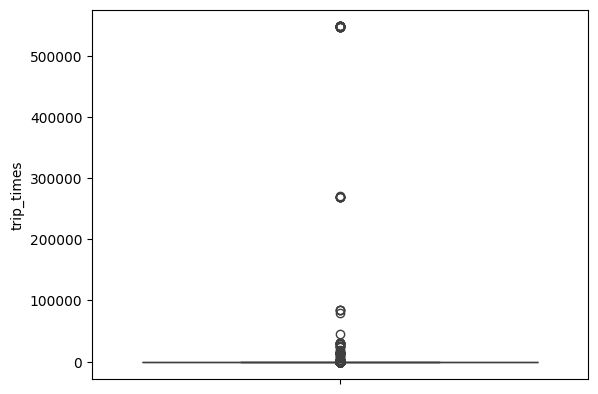

In [16]:
# the skewed box plot shows us the presence of outliers
sns.boxplot(y="trip_times", data=frame_with_durations)
plt.show()

In [17]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var = frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -1211.0166666666667
10 percentile value is 3.8333333333333335
20 percentile value is 5.383333333333334
30 percentile value is 6.816666666666666
40 percentile value is 8.3
50 percentile value is 9.95
60 percentile value is 11.866666666666667
70 percentile value is 14.283333333333333
80 percentile value is 17.633333333333333
90 percentile value is 23.45
100 percentile value is  548555.6333333333


In [18]:
#looking further from the 99th percecntile
for i in range(90,100):
    var = frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 23.45
91 percentile value is 24.35
92 percentile value is 25.383333333333333
93 percentile value is 26.55
94 percentile value is 27.933333333333334
95 percentile value is 29.583333333333332
96 percentile value is 31.683333333333334
97 percentile value is 34.46666666666667
98 percentile value is 38.71666666666667
99 percentile value is 46.75
100 percentile value is  548555.6333333333


In [19]:
# removing data based on our analysis and TLC regulations
frame_with_durations_modified = frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<720)]

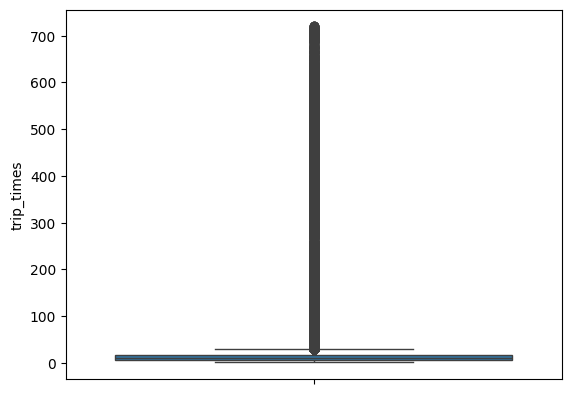

In [20]:
# box-plot after removal of outliers
sns.boxplot(y="trip_times", data=frame_with_durations_modified)
plt.show()

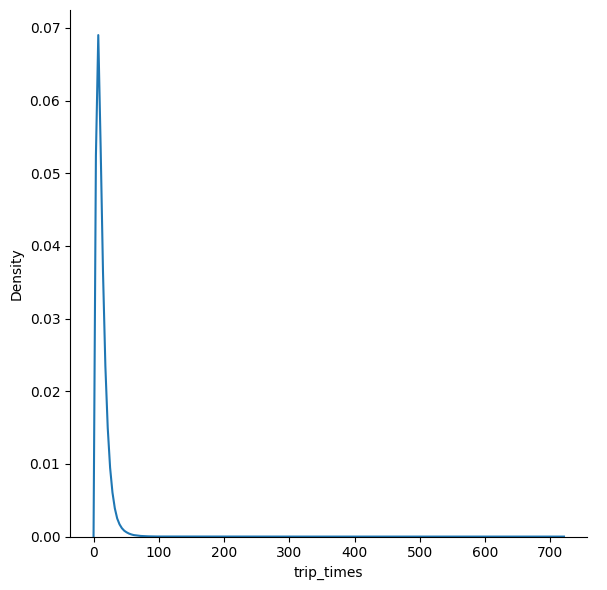

In [21]:
#pdf of trip-times after removing the outliers
sns.FacetGrid(frame_with_durations_modified, height=6) \
      .map(sns.kdeplot, "trip_times") \
      .add_legend()

plt.show()

In [22]:
# converting the values to log-values to chec for log-normal

frame_with_durations_modified.loc[:, 'log_times']=[math.log(i) for i in frame_with_durations_modified['trip_times'].values]

<ipython-input-22-e9c9c8c30f2b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_with_durations_modified.loc[:, 'log_times']=[math.log(i) for i in frame_with_durations_modified['trip_times'].values]


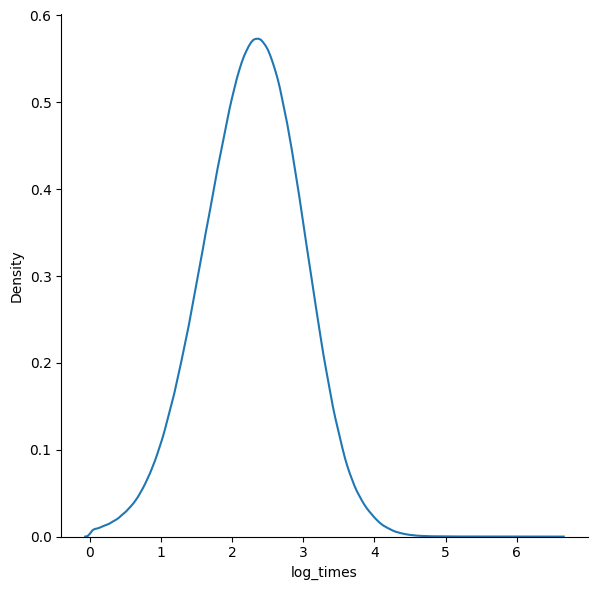

In [23]:
#pdf of log-values
sns.FacetGrid(frame_with_durations_modified, height=6) \
      .map(sns.kdeplot,"log_times") \
      .add_legend();
plt.show();

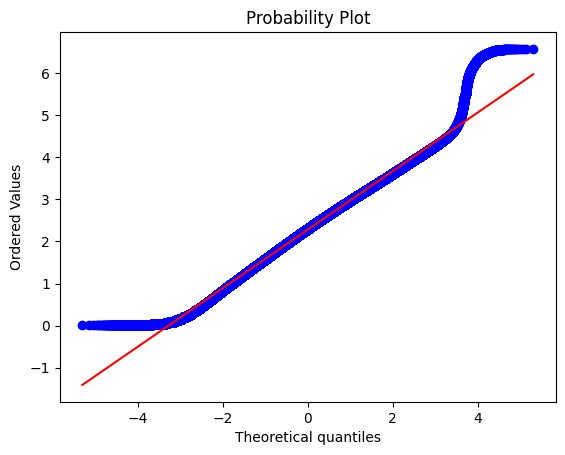

In [24]:
# Q-Q plot for checking if trip-times is log-normal

scipy.stats.probplot(frame_with_durations_modified['log_times'].values, plot=plt)
plt.show()

### 4. Speed

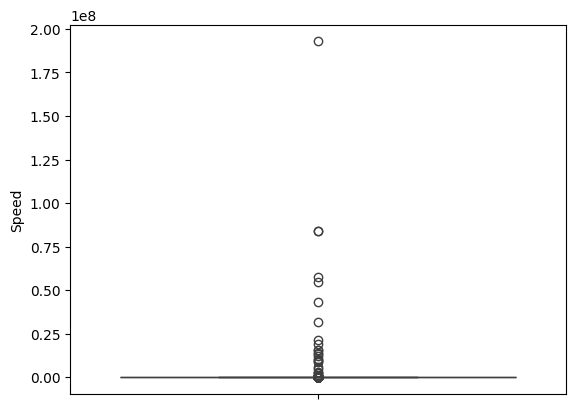

In [25]:
# check for any outliers in the data after trip duration outliers removed
# box-plot for speeds with outliers

frame_with_durations_modified.loc[:, 'Speed'] = 60*(frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])
sns.boxplot(y="Speed", data = frame_with_durations_modified)
plt.show()

In [26]:
# calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100
for i in range(0,100,10):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 6.409495548961425
20 percentile value is 7.80952380952381
30 percentile value is 8.929133858267717
40 percentile value is 9.98019801980198
50 percentile value is 11.06865671641791
60 percentile value is 12.286689419795222
70 percentile value is 13.796407185628745
80 percentile value is 15.963224893917962
90 percentile value is 20.186915887850468
100 percentile value is  192857142.85714284


In [27]:
# calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 20.186915887850468
91 percentile value is 20.91645569620253
92 percentile value is 21.752988047808763
93 percentile value is 22.721893491124263
94 percentile value is 23.844155844155843
95 percentile value is 25.182552504038775
96 percentile value is 26.80851063829787
97 percentile value is 28.84304932735426
98 percentile value is 31.591128254580514
99 percentile value is 35.7513566847558
100 percentile value is  192857142.85714284


In [28]:
# calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 35.7513566847558
99.1 percentile value is 36.31084727468969
99.2 percentile value is 36.91470054446461
99.3 percentile value is 37.588235294117645
99.4 percentile value is 38.33035714285714
99.5 percentile value is 39.17580340264651
99.6 percentile value is 40.15384615384615
99.7 percentile value is 41.338301043219076
99.8 percentile value is 42.86631016042781
99.9 percentile value is 45.3107822410148
100 percentile value is  192857142.85714284


In [29]:
# removing further outliers based on the 99.9th percentile value
frame_with_durations_modified = frame_with_durations[(frame_with_durations.Speed>0) & (frame_with_durations.Speed<45.31)]

In [30]:
# avg.speed of cabs in New-York
sum(frame_with_durations_modified["Speed"]) / float(len(frame_with_durations_modified["Speed"]))

12.450173996027528

- The avg speed in Newyork speed is 12.45miles/hr, so a cab driver can travel 2 miles per 10min on avg.

### 5. Trip Distance

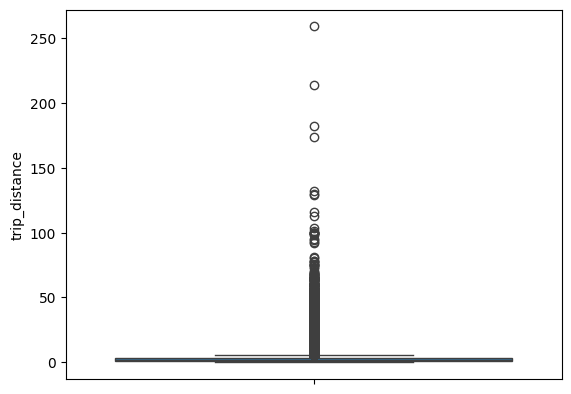

In [31]:
# till now we have removed the outliers based on trip durations and cab speeds
# lets try if there are any outliers in trip distances
# box-plot showing outliers in trip-distance values

sns.boxplot(y="trip_distance", data =frame_with_durations_modified)
plt.show()

In [32]:
# calculating trip distance values at each percntile 0,10,20,30,40,50,60,70,80,90,100
for i in range(0,100,10):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))

print("100 percentile value is ",var[-1])

0 percentile value is 0.01
10 percentile value is 0.66
20 percentile value is 0.9
30 percentile value is 1.1
40 percentile value is 1.39
50 percentile value is 1.69
60 percentile value is 2.07
70 percentile value is 2.6
80 percentile value is 3.6
90 percentile value is 5.97
100 percentile value is  258.9


In [33]:
# calculating trip distance values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 5.97
91 percentile value is 6.45
92 percentile value is 7.07
93 percentile value is 7.85
94 percentile value is 8.72
95 percentile value is 9.6
96 percentile value is 10.6
97 percentile value is 12.1
98 percentile value is 16.03
99 percentile value is 18.17
100 percentile value is  258.9


In [34]:
#calculating trip distance values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 18.17
99.1 percentile value is 18.37
99.2 percentile value is 18.6
99.3 percentile value is 18.83
99.4 percentile value is 19.13
99.5 percentile value is 19.5
99.6 percentile value is 19.96
99.7 percentile value is 20.5
99.8 percentile value is 21.22
99.9 percentile value is 22.57
100 percentile value is  258.9


In [35]:
# removing further outliers based on the 99.9th percentile value
frame_with_durations_modified = frame_with_durations[(frame_with_durations.trip_distance>0) & (frame_with_durations.trip_distance<23)]

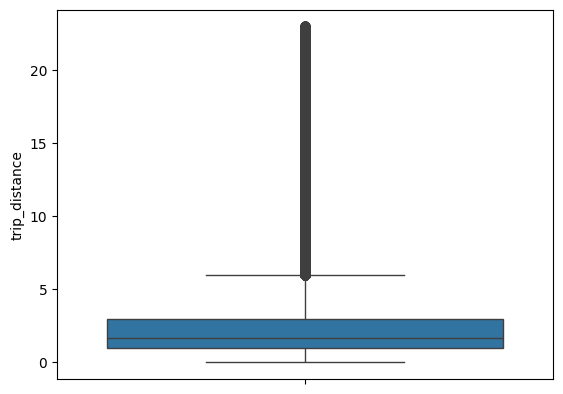

In [36]:
# box-plot after removal of outliers
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)
plt.show()

### 6. Total Fare

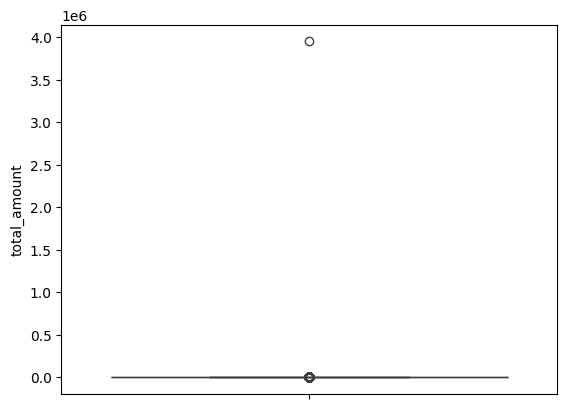

In [37]:
# till now we have removed the outliers based on trip durations, cab speeds, and trip distances
# lets try if there are any outliers in based on the total_amount
# box-plot showing outliers in fare

sns.boxplot(y="total_amount", data =frame_with_durations_modified)
plt.show()

In [38]:
# calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100
for i in range(0,100,10):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var, axis = None)
    print("{} percentile value is {}".format(i, var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -242.55
10 percentile value is 6.3
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 9.8
50 percentile value is 11.16
60 percentile value is 12.8
70 percentile value is 14.8
80 percentile value is 18.3
90 percentile value is 25.8
100 percentile value is  3950611.6


In [39]:
 # calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 25.8
91 percentile value is 27.3
92 percentile value is 29.3
93 percentile value is 31.8
94 percentile value is 34.8
95 percentile value is 38.53
96 percentile value is 42.6
97 percentile value is 48.13
98 percentile value is 58.13
99 percentile value is 66.13
100 percentile value is  3950611.6


In [40]:
# calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 66.13
99.1 percentile value is 68.13
99.2 percentile value is 69.6
99.3 percentile value is 69.6
99.4 percentile value is 69.73
99.5 percentile value is 69.75
99.6 percentile value is 69.76
99.7 percentile value is 72.58
99.8 percentile value is 75.35
99.9 percentile value is 88.28
100 percentile value is  3950611.6


- Observation:- even the 99.9th percentile value doesnt look like an outlier,as there is not much difference between the 99.8th percentile and 99.9th percentile, we move on to do graphical analyis.

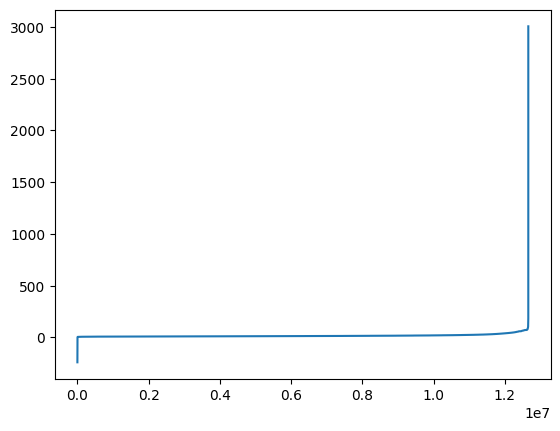

In [41]:
# below plot shows us the fare values(sorted) to find a sharp increase to remove those values as outliers
# plot the fare amount excluding last two values in sorted data

plt.plot(var[:-2])
plt.show()

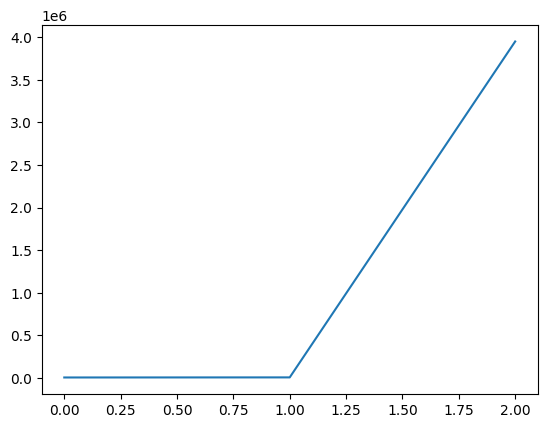

In [42]:
# a very sharp increase in fare values can be seen
# plotting last three total fare values, and we can observe there is share increase in the values
plt.plot(var[-3:])
plt.show()

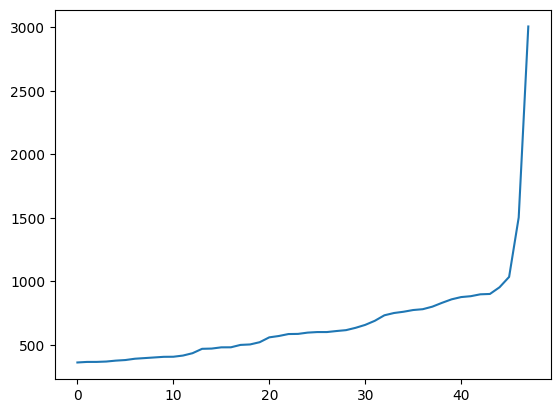

In [43]:
# now looking at values not including the last two points we again find a drastic increase at around 1000 fare value
# we plot last 50 values excluding last two values
plt.plot(var[-50:-2])
plt.show()

### Remove all outliers/erronous points.

In [31]:
#removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):

    a = new_frame.shape[0]
    print ("Number of pickup records = ",a)
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))


    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))


    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))

    temp_frame = new_frame[(new_frame.Speed <= 65) & (new_frame.Speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))

    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))


    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]

    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]

    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

In [32]:
print ("Removing outliers in the month of Jan-2015")
print ("------------------------------------------")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("fraction of data points that remain after removing outliers", float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

Removing outliers in the month of Jan-2015
------------------------------------------
Number of pickup records =  12748986
Number of outlier coordinates lying outside NY boundaries: 293919
Number of outliers from trip times analysis: 23889
Number of outliers from trip distance analysis: 92597
Number of outliers from speed analysis: 24473
Number of outliers from fare analysis: 5275
Total outliers removed 377910
---
fraction of data points that remain after removing outliers 0.9703576425607495


In [8]:
frame_with_durations_outliers_removed.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421349e+09,5.285319
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420922e+09,9.983193
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420922e+09,10.746269
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420922e+09,16.071429
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420922e+09,9.318378


## Data Preperation

### 1. Clustering

In [33]:
coords = frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values

# Function to calculate minimum distance and inter-cluster statistics
def find_min_distance(cluster_centers, cluster_len):
    min_dist = 1000
    within_vicinity = []
    outside_vicinity = []

    # Calculate the inter-cluster distances
    for i in range(cluster_len):
        nice_points, wrong_points = 0, 0
        for j in range(cluster_len):
            if j != i:
                distance = gpxpy.geo.haversine_distance(
                    cluster_centers[i][0], cluster_centers[i][1],
                    cluster_centers[j][0], cluster_centers[j][1]
                ) / (1.60934 * 1000)  # Convert to kilometers
                min_dist = min(min_dist, distance)
                if distance <= 2:
                    nice_points += 1
                else:
                    wrong_points += 1
        within_vicinity.append(nice_points)
        outside_vicinity.append(wrong_points)

    # Print the statistics
    print(f"Cluster size {cluster_len}:")
    print(f"Avg. Clusters within vicinity (distance < 2 km): {np.ceil(np.mean(within_vicinity))}")
    print(f"Avg. Clusters outside vicinity (distance > 2 km): {np.ceil(np.mean(outside_vicinity))}")
    print(f"Min inter-cluster distance: {min_dist} km\n---")

# Function to fit KMeans and return cluster centers and their count
def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000, random_state=42)
    kmeans.fit(coords)
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(coords)
    return kmeans.cluster_centers_, len(kmeans.cluster_centers_)

# Try different cluster sizes (from 10 to 90 clusters)
for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)


Cluster size 10:
Avg. Clusters within vicinity (distance < 2 km): 2.0
Avg. Clusters outside vicinity (distance > 2 km): 7.0
Min inter-cluster distance: 0.9942822667922672 km
---
Cluster size 20:
Avg. Clusters within vicinity (distance < 2 km): 5.0
Avg. Clusters outside vicinity (distance > 2 km): 14.0
Min inter-cluster distance: 0.6444725834028739 km
---
Cluster size 30:
Avg. Clusters within vicinity (distance < 2 km): 9.0
Avg. Clusters outside vicinity (distance > 2 km): 21.0
Min inter-cluster distance: 0.47920626820356643 km
---
Cluster size 40:
Avg. Clusters within vicinity (distance < 2 km): 11.0
Avg. Clusters outside vicinity (distance > 2 km): 29.0
Min inter-cluster distance: 0.36064577963428435 km
---
Cluster size 50:
Avg. Clusters within vicinity (distance < 2 km): 13.0
Avg. Clusters outside vicinity (distance > 2 km): 37.0
Min inter-cluster distance: 0.37726530352041876 km
---
Cluster size 60:
Avg. Clusters within vicinity (distance < 2 km): 16.0
Avg. Clusters outside vicinity

#### Inference:
- The main objective was to find an optimal min. distance(Which roughly estimates to the radius of a cluster) between the clusters.
- A hueristic for min distance between any two clusters is set as 0.5 miles
- This is achieved when no. of clusters is 30

In [34]:
kmeans = MiniBatchKMeans(n_clusters=30, batch_size=10000, random_state=42)
kmeans.fit(coords)

MiniBatchKMeans(batch_size=10000, n_clusters=30, random_state=42)

In [11]:
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values)

In [12]:
frame_with_durations_outliers_removed['pickup_cluster'].head()

,pickup_cluster
0,25
1,28
2,29
3,23
4,15


#### plotting the clusters centers

In [51]:
# Plotting the cluster centers on OSM
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)

map_osm = folium.Map(location=[40.734695, -73.990372])

for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

#### plotting the clusters

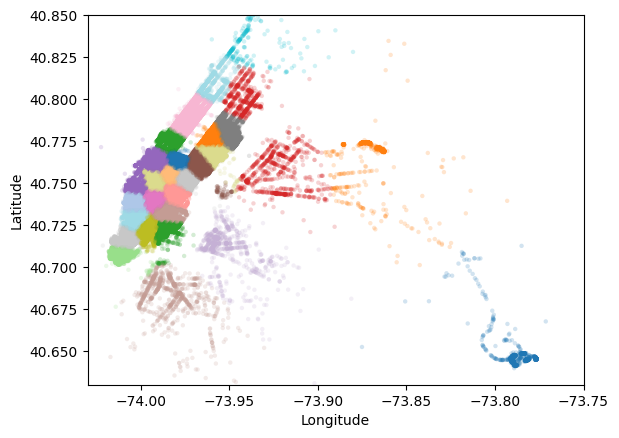

In [50]:
#Visualising the clusters on a map
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10, lw=0,
               c=frame.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_clusters(frame_with_durations_outliers_removed)

### 2. Time Binning

- Since we want to predict the no. of pickups at a given timestamp, we divide the time into bins(intervals) of 10 minutes and allocate each pickup to particular bin.
- Note: Selecting the size of the bin (10 mins) depends on the individual and is not a rule
- Currently we have the data for the month of Jan-2015, so by using the unix timestamp we will divide the time.
- No. of minutes in the month of Jan = (24 * 60 * 31) = 44640
- So if we divide the time into 10 min intervals, we will have 44640/10 = **4464* bins (for the month on Jan 2015 only)

In [13]:
#Refer: https://www.unixtimestamp.com/
# 1420070400 : 2015-01-01 00:00:00
# 1422748800 : 2015-02-01 00:00:00
# 1425168000 : 2015-03-01 00:00:00
# 1427846400 : 2015-04-01 00:00:00
# 1430438400 : 2015-05-01 00:00:00
# 1433116800 : 2015-06-01 00:00:00

def add_pickup_bins(frame, month, year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    # Below are unix timestamps for Jan 01 2015, Feb 01 2015, and so on....
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]

    start_pickup_unix=unix_times[year-2015][month-1]
    # https://www.timeanddate.com/time/zones/est
    # (int((i-start_pickup_unix)/600)+33) : our unix time is in gmt to we are converting it to est
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [14]:
# clustering, making pickup bins and grouping by pickup cluster and pickup bins
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values)

jan_2015_frame = add_pickup_bins(frame_with_durations_outliers_removed, 1, 2015)
jan_2015_groupby = jan_2015_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

In [15]:
# we add two more columns 'pickup_cluster'(to which cluster it belogns to)
# and 'pickup_bins' (to which 10min intravel the trip belongs to)
jan_2015_frame.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed,pickup_cluster,pickup_bins
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421349e+09,5.285319,25,2163
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420922e+09,9.983193,28,1452
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420922e+09,10.746269,29,1452
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420922e+09,16.071429,23,1452
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420922e+09,9.318378,15,1452


In [16]:
jan_2015_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              33                     140
               34                     221
               35                     145
               36                      96
               37                     100

In [55]:
# hear the trip_distance represents the number of pickups that are happend in that particular 10min intravel
# - primary index: pickup_cluster (cluster number)
# - secondary index : pickup_bins (we divide whole month time into 10-min intravels 243160/10 = 4464 bins)

# - Explanation:
# In cluster 0, there were 97 pickups in bin 1;
# In cluster 0, there were 198 pickups in bin 2; and so on...

##### Preparing the data for Jan 2016 - test data

- Note: For cleaning and preparing the test (Jan 2016) data, we use the same parameters that we found while analysing the train (Jan 2015) data. We must not perform the analysis, cleaning, processing, etc. on the test data separately because that is not possible after the model is deployed.

In [17]:
# Uptil now we cleaned data and prepared data for the month Jan 2015.
# Now do the same operations for month of Jan 2016 which we will use for testing purpose.

# Steps:
# 1. get the dataframe which inlcudes only required colums
# 2. adding trip times, speed, unix time stamp of pickup_time
# 4. remove the outliers based on trip_times, speed, trip_duration, total_amount
# 5. add pickup_cluster to each data point (using kmeans clustering)
# 6. add pickup_bin (index of 10 min interval to which that trip belongs to)
# 7. group by data, based on 'pickup_cluster' and 'pickup_bin'

# Data Preparation for the month of Jan 2016
def datapreparation(month, kmeans, month_no, year_no):

    print ("Return with trip times..")

    frame_with_durations = return_with_trip_times(month)

    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)

    print ("Estimating clusters..")
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame.groupby(['pickup_cluster', 'pickup_bins']).trip_distance.agg(no_of_trips='count')

    return final_updated_frame, final_groupby_frame

In [18]:
# month_jan_2016 = dd.read_csv(df)
# df = dd.read_csv('your_file.csv', dtype={'tip_amount': 'float64', 'tolls_amount': 'float64'})
month_jan_2016 = dd.read_csv('/content/drive/My Drive/yellow_tripdata_2016-01.csv', assume_missing=True)

In [19]:
jan_2016_frame, jan_2016_groupby = datapreparation(month_jan_2016, kmeans, 1, 2016)

Return with trip times..
Remove outliers..
Number of pickup records =  10906858
Number of outlier coordinates lying outside NY boundaries: 214677
Number of outliers from trip times analysis: 27190
Number of outliers from trip distance analysis: 79742
Number of outliers from speed analysis: 21047
Number of outliers from fare analysis: 4991
Total outliers removed 297784
---
Estimating clusters..


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MiniBatchKMeans was fitted without feature names
  warnings.warn(


Final groupbying..


In [34]:
file_path1 = '/content/drive/My Drive/jan_2016_frame.csv'
file_path2 = '/content/drive/My Drive/jan_2016_groupby.csv'

jan_2016_frame.to_csv(file_path1, index=False)
jan_2016_groupby.to_csv(file_path2, index=False)

print(f"DataFrame saved to {file_path1}")
print(f"DataFrame saved to {file_path2}")


DataFrame saved to /content/drive/My Drive/jan_2016_frame.csv
DataFrame saved to /content/drive/My Drive/jan_2016_groupby.csv


In [35]:
file_path1 = '/content/drive/My Drive/jan_2015_frame.csv'
file_path2 = '/content/drive/My Drive/jan_2015_groupby.csv'

jan_2015_frame.to_csv(file_path1, index=False)
jan_2015_groupby.to_csv(file_path2, index=False)

print(f"DataFrame saved to {file_path1}")
print(f"DataFrame saved to {file_path2}")

DataFrame saved to /content/drive/My Drive/jan_2015_frame.csv
DataFrame saved to /content/drive/My Drive/jan_2015_groupby.csv


In [4]:
jan_2015_frame = pd.read_csv('/content/drive/My Drive/jan_2015_frame.csv')

jan_2015_groupby = pd.read_csv('/content/drive/My Drive/jan_2015_groupby.csv')

jan_2016_frame = pd.read_csv('/content/drive/My Drive/jan_2016_frame.csv')

jan_2016_groupby = pd.read_csv('/content/drive/My Drive/jan_2016_groupby.csv')

### 3. Smoothing

In [5]:
# Gets the unique bins where pickup values are present for each reigion

# for each cluster region we will collect all the indices of 10-min intervals in which the pickups happened
# we got an observation that there are some pickup_bins that do not have any pickups
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,30):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [6]:
# For Jan month we get all indices of 10-min intervals in which atleast one pickup got happened

jan_2015_unique = return_unq_pickup_bins(jan_2015_frame)
jan_2016_unique = return_unq_pickup_bins(jan_2016_frame)

In [7]:
total = 0
for i in range(30):
    total += (4464 - len(jan_2015_unique[i]))
print("Total no. of bins (across all clusters) with zero pickups in Jan 2015 = ",total)

Total no. of bins (across all clusters) with zero pickups in Jan 2015 =  1237


In [12]:
# for each cluster number of 10-min intervals with 0 pickups
print("Below is the list of no. of zero pickups in each cluster of Jan 2015")
print('*'*70)
for i in range(30):
    print("For",i,"th cluster, number of 10 min intervals with zero pickups: ",4464 - len(jan_2015_unique[i]))
    print('-'*60)

Below is the list of no. of zero pickups in each cluster of Jan 2015
**********************************************************************
For 0 th cluster, number of 10 min intervals with zero pickups:  31
------------------------------------------------------------
For 1 th cluster, number of 10 min intervals with zero pickups:  112
------------------------------------------------------------
For 2 th cluster, number of 10 min intervals with zero pickups:  39
------------------------------------------------------------
For 3 th cluster, number of 10 min intervals with zero pickups:  39
------------------------------------------------------------
For 4 th cluster, number of 10 min intervals with zero pickups:  37
------------------------------------------------------------
For 5 th cluster, number of 10 min intervals with zero pickups:  31
------------------------------------------------------------
For 6 th cluster, number of 10 min intervals with zero pickups:  36
-----------------

- We need to fill these missing values with 0's for Jan 2016 data which will be used for building models

In [8]:
# Fills a value of zero for every bin where no pickup data is present
# the count_values: number of pickps that are happened in each region for each 10min interval
# there wont be any value if there are no pickups.
# values: number of unique bins

# for every 10min interval(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add 0 to the smoothed data
# we finally return smoothed data
def fill_missing(count_values, values):
    smoothed_regions=[]
    ind=0  # ind iterates over count_values only
    for r in range(0,30):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [9]:
# Filling Missing values of Jan-2016 with 0
# Remember: the "no_of_trips" represents the number of pickups that happened
jan_2016_smooth = fill_missing(jan_2016_groupby['no_of_trips'].values,jan_2016_unique)

In [10]:
# number of 10 min indices for jan 2016 = 24*31*60/10 = 4464
# for each cluster we will have 4464 values
# therefore length of the jan_2016_smooth =  30*4464 = 133920
print("number of 10 min intervals among all the clusters ",len(jan_2016_smooth))

number of 10 min intervals among all the clusters  133920


In [11]:
baseline_df = pd.DataFrame()
baseline_df['Prediction']=jan_2016_smooth

In [12]:
baseline_df.shape

(133920, 1)

In [18]:
baseline_df['Prediction'].unique()

array([  0, 136, 186, 142, 109,  94, 128, 138, 140, 108, 122, 115, 141,
       131, 150, 110, 130, 116, 126, 101,  89,  75,  59,  47,  49,  51,
        35,  23,  29,  40,  33,  36,  31,  42,  39,  30,  32,  34,  27,
        37,  52,  60,  53,  81,  82,  71,  72,  97,  96, 105, 103, 118,
       100, 143, 134, 147, 154, 161, 148, 129, 152, 145, 146, 159, 169,
       163, 168, 208, 181, 173, 209, 179, 199, 184, 175, 172, 177, 160,
       153, 162, 171, 188, 166, 198, 191, 158, 178, 156, 137, 120, 121,
       123,  95, 114, 155, 111, 151, 144,  63,  74,  66,  58,  50,  44,
        25,  24,  19,  22,  28,  26,  20,  21,  15,  16,  13,  18,  14,
        17,  45,  64,  67,  65,  83, 107, 149, 185, 183, 190, 213, 189,
       180, 174, 187, 194, 210, 197, 206, 211, 207, 205, 196, 217, 222,
       133, 157, 182, 135, 193,  85,  77,  87,  69,  54,  43,  56,  41,
        11,  38,  57,  73, 104,  93, 192, 176, 170, 201, 167, 195, 165,
       119, 106, 125,  88,  78,  86,  84,  76,  48,  12,   7,   

In [19]:
baseline_df.head(10)

,Prediction
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


### 4. Modelling: Baseline Models

Now we get into modelling in order to forecast the pickup densities for the months of Jan of 2016 for which we are using multiple models with two variations
1. Using Previous known values of the 2016 data itself to predict the future values

#### 4.1 Simple Moving Averages

The First Model used is the Moving Averages Model which uses the previous n values in order to predict the next value


Using Ratio Values - $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3} .... R_{t-n} )/n \end{align}$

In [13]:
def MA_Predictions(df, window_size):
    # window_size is the hyperparameter
    predicted_value=(df['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    for i in range(0,4464*30):
        k = i%4464
        if k == 0:
            predicted_values.append(0)
            error.append(0)
            predicted_value=(df['Prediction'].values)[i]
            continue
        predicted_values.append(predicted_value)
        error.append(abs(predicted_value-(df['Prediction'].values)[i]))
        if k+1>=window_size:
            predicted_value=int(sum((df['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((df['Prediction'].values)[i-k:(i+1)])/k)

    df['MA_Predicted'] = predicted_values
    df['MA_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(df['Prediction'].values)/len(df['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return df,mape_err,mse_err

In [14]:
# Hyperparameter Tuning
for i in range(1,6):
    _,mean_err,median_err = MA_Predictions(baseline_df, i)
    print("For win_size =", i, "MAPE =", mean_err, "MSE =", median_err)

For win_size = 1 MAPE = 0.13559887346598937 MSE = 290.821146953405
For win_size = 2 MAPE = 0.13206860454931602 MSE = 277.0453927718041
For win_size = 3 MAPE = 0.1368817057086271 MSE = 295.9540397252091
For win_size = 4 MAPE = 0.1448485503013007 MSE = 327.03401284348865
For win_size = 5 MAPE = 0.1537858574382869 MSE = 363.19504181600956


For the above the Hyperparameter window-size, which is tuned manually and it is found that the window-size of 2 is optimal for getting the best results using Simple Moving Averages for previous 2016 values

In [22]:
baseline_df, mean_err, median_err = MA_Predictions(baseline_df, 2)
baseline_df.head()

,Prediction,MA_Predicted,MA_Error
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


#### 4.2 Weighted Moving Averages


The Moving Avergaes Model used gave equal importance to all the values in the window used, but we know intuitively that the future is more likely to be similar to the latest values and less similar to the older values. Weighted Averages converts this analogy into a mathematical relationship giving the highest weight while computing the averages to the latest previous value and decreasing weights to the subsequent older ones

Weighted Moving Averages using Ratio Values - $\begin{align}R_{t} = ( N*R_{t-1} + (N-1)*R_{t-2} + (N-2)*R_{t-3} .... 1*R_{t-n} )/(N*(N+1)/2) \end{align}$

In [15]:
def WA_Predictions(df, window_size):
    # window_size is the hyperparameter
    predicted_value=(df['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    for i in range(0,4464*30):
        k=i%4464
        if k==0:
            predicted_values.append(0)
            error.append(0)
            predicted_value=(df['Prediction'].values)[i]
            continue
        predicted_values.append(predicted_value)
        error.append(abs(predicted_value-(df['Prediction'].values)[i]))
        if k+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(df['Prediction'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(k,0,-1):
                sum_values += j*(df['Prediction'].values)[i-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

    df['WA_Predicted'] = predicted_values
    df['WA_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(df['Prediction'].values)/len(df['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return df,mape_err,mse_err

In [16]:
# Hyperparameter tuning
for i in range (1, 6):
    _,mean_err,median_err = WA_Predictions(baseline_df, i)
    print("For win_size =", i, "MAPE =", mean_err, "MSE =", median_err)

For win_size = 1 MAPE = 0.13559887346598937 MSE = 290.821146953405
For win_size = 2 MAPE = 0.12959128418622262 MSE = 265.59493727598567
For win_size = 3 MAPE = 0.13071169552401432 MSE = 269.5392771804062
For win_size = 4 MAPE = 0.13445984844683948 MSE = 283.1618951612903
For win_size = 5 MAPE = 0.13933956201913278 MSE = 301.24159199522103


In [17]:
baseline_df, mean_err, median_err = WA_Predictions(baseline_df, 2)
baseline_df.head()

,Prediction,MA_Predicted,MA_Error,WA_Predicted,WA_Error
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


#### 4.3 Exponential Weighted Moving Averages


 https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average
Through weighted averaged we have satisfied the analogy of giving higher weights to the latest value and decreasing weights to the subsequent ones but we still do not know which is the correct weighting scheme as there are infinetly many possibilities in which we can assign weights in a non-increasing order and tune the the hyperparameter window-size. To simplify this process we use Exponential Moving Averages which is a more logical way towards assigning weights and at the same time also using an optimal window-size.

In exponential moving averages we use a single hyperparameter alpha $\begin{align}(\alpha)\end{align}$ which is a value between 0 & 1 and based on the value of the hyperparameter alpha the weights and the window sizes are configured.<br>
For eg. If $\begin{align}\alpha=0.9\end{align}$ then the number of days on which the value of the current iteration is based is~$\begin{align}1/(1-\alpha)=10\end{align}$ i.e. we consider values 10 days prior before we predict the value for the current iteration. Also the weights are assigned using $\begin{align}2/(N+1)=0.18\end{align}$ ,where N = number of prior values being considered, hence from this it is implied that the first or latest value is assigned a weight of 0.18 which keeps exponentially decreasing for the subsequent values.

$\begin{align}R^{'}_{t} = \alpha*R_{t-1} + (1-\alpha)*R^{'}_{t-1}  \end{align}$

In [18]:
def EA_Predictions(df, alpha):
    # alpha is the hyperparameter
    predicted_value= (df['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            predicted_value= (df['Prediction'].values)[i]
            continue
        predicted_values.append(predicted_value)
        error.append(abs(predicted_value-(df['Prediction'].values)[i]))

        # Predicted(t) = alpha*Actual(t-1) + (1-alpha)*Predicted(t-1)
        predicted_value =int((alpha*((df['Prediction'].values)[i])) + (1-alpha)*predicted_value)

    df['EA_Predicted'] = predicted_values
    df['EA_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(df['Prediction'].values)/len(df['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return df,mape_err,mse_err

In [19]:
# Hyperparameter tuning
for i in np.linspace(0.1,1,10):
    _,mean_err,median_err = EA_Predictions(baseline_df, i)
    print("For alpha =", i, "MAPE =", mean_err, "MSE =", median_err)

For alpha = 0.1 MAPE = 0.26432977093928134 MSE = 965.223133213859
For alpha = 0.2 MAPE = 0.1838640547419865 MSE = 495.0212813620072
For alpha = 0.30000000000000004 MAPE = 0.1540703538574209 MSE = 357.0424208482676
For alpha = 0.4 MAPE = 0.14000039495019329 MSE = 300.3422640382318
For alpha = 0.5 MAPE = 0.13301251661412788 MSE = 274.5049507168459
For alpha = 0.6 MAPE = 0.13005265782110514 MSE = 264.42485812425326
For alpha = 0.7000000000000001 MAPE = 0.12935714864101702 MSE = 262.719041218638
For alpha = 0.8 MAPE = 0.13014364754266808 MSE = 266.98908303464754
For alpha = 0.9 MAPE = 0.13226768590272528 MSE = 276.4890681003584
For alpha = 1.0 MAPE = 0.13559887346598937 MSE = 290.821146953405


In [20]:
# Tuning the value of alpha between 0.6 and 0.8
for i in np.linspace(.6, .8, 9):
    _,mean_err,median_err = EA_Predictions(baseline_df, i)
    print("For alpha =", i, "MAPE =", mean_err, "MSE =", median_err)

For alpha = 0.6 MAPE = 0.13005265782110514 MSE = 264.42485812425326
For alpha = 0.625 MAPE = 0.1297136431575871 MSE = 263.3373133213859
For alpha = 0.65 MAPE = 0.12947723995576937 MSE = 262.7617906212664
For alpha = 0.675 MAPE = 0.12941270622801496 MSE = 262.58997909199525
For alpha = 0.7 MAPE = 0.12935771555517006 MSE = 262.7101553166069
For alpha = 0.7250000000000001 MAPE = 0.12942961916691398 MSE = 263.3204375746715
For alpha = 0.75 MAPE = 0.12956161567888017 MSE = 264.0803166069295
For alpha = 0.775 MAPE = 0.12981587667651867 MSE = 265.42706839904423
For alpha = 0.8 MAPE = 0.13014364754266808 MSE = 266.98908303464754


For the above the Hyperparameter window-size, which is tuned manually and it is found that the alpha of 0.7 is optimal for getting the best results using Exponentially Weighted Moving Averages for previous 2016 values therefore we get:

$\begin{align}P^{'}_{t} = 0.7*P_{t-1} + 0.3*P^{'}_{t-1}  \end{align}$

In [21]:
baseline_df, mean_err, median_err = EA_Predictions(baseline_df, 0.7)

In [22]:
baseline_df.head()

,Prediction,MA_Predicted,MA_Error,WA_Predicted,WA_Error,EA_Predicted,EA_Error
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0


In [23]:
baseline_df.tail()

,Prediction,MA_Predicted,MA_Error,WA_Predicted,WA_Error,EA_Predicted,EA_Error
133915,10,6,4,5,5,4,6
133916,10,6,4,8,2,8,2
133917,6,7,1,10,4,9,3
133918,3,7,4,7,4,6,3
133919,4,6,2,4,0,3,1


### 5. Comparison between baseline models


We have chosen our error metric for comparison between models as MAPE (Mean Absolute Percentage Error) so that we can know that on an average how good is our model with predictions and MSE (Mean Squared Error) is also used so that we have a clearer understanding as to how well our forecasting model performs with outliers so that we make sure that there is not much of a error margin between our prediction and the actual value

From the above values it is inferred that the best forecasting baseline model for our prediction would be:-  

$\begin{align}P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}  \end{align}$

 i.e Exponential Moving Averages using 2016 Values



## Regression Models



### Data Preparation

For using the regression ML algorithms, we create the following dataset:

Features:

- Latitude of the cluster
- Longitude of the cluster
- No. of pickups in the last 10-min bin in that cluster
- No. of pickups in the second last 10-min bin in that cluster
- No. of pickups in the third last 10-min bin in that cluster
- No. of pickups in the fourth last 10-min bin in that cluster
- No. of pickups in the fifth last 10-min bin in that cluster
- Exponentially weighted average prediction for the current bin in that cluster

Output variable

- The number of pickups in the current bin of a given cluster


No of features = 8

 From the baseline models we said the exponential weighted moving avarage gives us the least error, so we will try to add the same exponential weighted moving avarage at timestamp = t as a feature to our data for regression.

#### Train-Test Split

Clearly this is a time series problem and we already have the no. of pickups sorted by time(10-min time bin) for each cluster. So we will do a 70-30 time-based split and not a random split.


In [50]:
len(jan_2016_smooth)

133920

"jan_2016_smooth" is a flattened list which contains the no. of pickups for all the 4464 pickup bins in all the 30 clusters, i.e.

- jan_2016_smooth[0:4464] => no. of pickups in all the bins of cluster 0
- jan_2016_smooth[4464:4464*2] => no. of pickups in all the bins of cluster 1
- jan_2016_smooth[4464*2:4464*3] => no. of pickups in all the bins of cluster 2
- And so on ...

Now we create a list named "regions" which is a list of lists. It contains 30 lists, each of which will contain 4464 values which represent the number of pickups that happened for Jan 2016 in 30 different clusters, i.e.

- regions[0]=> contains 4464 values corresponding to no. of pickups in all the bins of cluster 0
- regions[1]=> contains 4464 values corresponding to no. of pickups in all the bins of cluster 1
- regions[2]=> contains 4464 values corresponding to no. of pickups in all the bins of cluster 2
- And so on ....
- regions[29]=> contains 4464 values corresponding to no. of pickups in all the bins of cluster 29

In [24]:
# Making list of all the values of pickup data in every bin for Jan 2016 and storing them region-wise
regions = []

for i in range(0,30):
    regions.append(jan_2016_smooth[4464*i:4464*(i+1)])

#### Creating latitude and Longitude features
latitude will contain 30 lists corresponding to each cluster:

- latitude[0] => contains latitude of cluster 0, repeated 4459 times
- latitude[1] => contains latitude of cluster 1, repeated 4459 times
- And so on ...
- latitude[29] => contains latitude of cluster 29, repeated 4459 times

Similarly, longitude will contain 30 lists corresponding to each cluster:

- longitude[0] => contains longitude of cluster 0, repeated 4459 times
- longitude[1] => contains longitude of cluster 1, repeated 4459 times
- And so on ...
- longitude[29] => contains longitude of cluster 29, repeated 4459 times

Since we decided that for every data point, we'll have the no. of pickups in the last five 10-min intervals as features of the data point, so we consider the bins from 5 to 4463 (instead of 0 to 4463), because we will not have 5 previous bins for the first 5 bins.

In [35]:
latitude = []
longitude = []
for i in range(0,30):
    latitude.append([kmeans.cluster_centers_[i][0]]*4459)
    longitude.append([kmeans.cluster_centers_[i][1]]*4459)

#### Creating the features corresponding to the no. of pickups in the last five 10-min bins

In [36]:
previous_5_bin_pickups=[]
for i in range(30):
    cluster_i_features=[]
    for r in range(4459):
        cluster_i_features.append(regions[i][r:r+5])
    previous_5_bin_pickups.append(cluster_i_features)

Note: previous_5_bin_pickups is a list of list of lists

- Outer list contains 30 values (corresponding to each cluster)
- Each of the Middle list contains 4459 values corresponding to each bin for the given cluster
- Each of the innermost list contain 5 values corresponding to the no. of pickups in the last five 10-min bins for a given bin

In [54]:
len(previous_5_bin_pickups)


30

In [55]:
len(previous_5_bin_pickups[0])


4459

In [56]:
len(previous_5_bin_pickups[0][0])


5

We convert the previous_5_bin_pickups into a numpy array by stacking all the features vertically, one above the other.

In [37]:
previous_5_bin_pickups = np.vstack(previous_5_bin_pickups)
previous_5_bin_pickups.shape

(133770, 5)

#### Creating the output variable (yi)


In [38]:
# output varaible
# it is list of lists
# it will contain number of pickups (4459) for each cluster
output = []
for i in range(0,30):
    output.append(regions[i][5:])

In [59]:
len(output)


30

In [60]:
len(output[0])


4459

#### Creating feature for exponentially weighted average prediction for each bin in each cluster


In [39]:
# We use the same alpha which we found using hyperparameter searh
alpha=0.3

# predicted_values is a temporary array that stores exponential weighted moving avarage
# for every 10-min bin in cluster 'i'
predicted_values=[]

# exp_avg_pred is a list of lists similar to latitude or longitude; it contains values as follows:
# [[x5,x6,x7,....,x4463],        cluster 0
#  [x5,x6,x7,....,x4463],        cluster 1
#  [x5,x6,x7,....,x4463],        cluster 2
#  And so on .....,
#  [x5,x6,x7,....,x4463]]        cluster 39
exp_avg_pred = []

# Below code is similar to the code written in the function "EA_Predictions" in Baseline models
# With only minor modifications
for r in range(0,30):
    for i in range(0,4464):
        if i%4464==0:
            predicted_value = regions[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions[r][i]))
    exp_avg_pred.append(predicted_values[5:])
    predicted_values=[]

In [62]:
len(exp_avg_pred)


30

In [63]:
len(exp_avg_pred[0])


4459

#### Calculating the size of training and test sets in terms of no. of bins for one cluster


In [64]:
print("size of train data :", int(4459*0.7))      # First 70%
print("size of test data :", 4459-int(4459*0.7))  # Last 30%

size of train data : 3121
size of test data : 1338


his means that, from every cluster the first 3121 data points will go to the training set and the last 1338 points will go to the test set.

Thus:

- Total no. of points in training set = 3121*40 = 124840
- Total no. of points in test set = 1338*40 = 53520

#### Train-Test Split
#### Splitting "previous_5_bin_pickups"

In [40]:
# extracting first 3121 timestamp values for our training data from each cluster
train_features =  [previous_5_bin_pickups[i*4459:(4459*i+3121)] for i in range(0,30)]

# extracting last 1338 timestamp values for our test data from each cluster
test_features = [previous_5_bin_pickups[(4459*i)+3121:4459*(i+1)] for i in range(0,30)]

In [66]:
len(train_features), len(train_features[0]), len(train_features[0][0])


(30, 3121, 5)

Thus in the train set, for all the 30 clusters, we have data of the initial 3121 10-min bins and each data point contains 5 features corresponding to the no. of pickups in the last five 10-min bins.

In [67]:
len(test_features), len(test_features[0]), len(test_features[0][0])


(30, 1338, 5)

Thus in the test set, for all the 40 clusters, we have data of the last 1338 10-min bins and eah data point contains 5 features corresponding to the no. of pickups in the last five 10-min bins.

#### Splitting "latitude", "longitude", "output" and "exp_avg_pred"


In [41]:
# extracting first 3321 timestamp values i.e 70% of 4459 (total timestamps) for our training data
train_lat = [i[:3121] for i in latitude]
train_lon = [i[:3121] for i in longitude]
train_output = [i[:3121] for i in output]
train_exp_avg = [i[:3121] for i in exp_avg_pred]

In [42]:
# extracting the rest of the timestamp values i.e 30% of 4459 (total timestamps) for our test data
test_lat = [i[3121:] for i in latitude]
test_lon = [i[3121:] for i in longitude]
test_output = [i[3121:] for i in output]
test_exp_avg = [i[3121:] for i in exp_avg_pred]

Important:
- We have all the training and test set features in the form of list of lists; where data corresponding to each cluster is present in a separate list.
- So we flatten all these nested lists into one single list - This is equivalent to concatenting the data for all the clusters into a single list.
- This is done both for the train set as well as for the test set .

#### Flattening the "train_features" and "test_features" lists

In [43]:
# the above contains values in the form of list of lists (i.e. list of values of each region),
# here we make all of them in one list
train_flat_features = []
for i in range(0,30):
    train_flat_features.extend(train_features[i])

test_flat_features = []
for i in range(0,30):
    test_flat_features.extend(test_features[i])

#### Flattening the latitude, longitude, output and exp_avg_pred features of the train set



In [44]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]
# Explanation => https://stackoverflow.com/a/33542010/8528893

train_flat_lat = sum(train_lat, [])
train_flat_lon = sum(train_lon, [])
train_flat_output = sum(train_output, [])
train_flat_exp_avg = sum(train_exp_avg,[])

#### Flattening the latitude, longitude, output and exp_avg_pred features of the test set



In [45]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]
# Explanation => https://stackoverflow.com/a/33542010/8528893

test_flat_lat = sum(test_lat, [])
test_flat_lon = sum(test_lon, [])
test_flat_output = sum(test_output, [])
test_flat_exp_avg = sum(test_exp_avg,[])

##### Finally preparing a dataframe which contains all the features

In [46]:
# Train Dataframe
# Preparing the data frame for our train data
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_flat_features, columns=columns)
df_train['lat'] = train_flat_lat
df_train['lon'] = train_flat_lon
df_train['exp_avg'] = train_flat_exp_avg

print(df_train.shape)


(93630, 8)


In [74]:
df_train.head()


,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,exp_avg
0,0,0,0,0,0,40.763505,-73.978905,0
1,0,0,0,0,0,40.763505,-73.978905,0
2,0,0,0,0,0,40.763505,-73.978905,0
3,0,0,0,0,0,40.763505,-73.978905,0
4,0,0,0,0,0,40.763505,-73.978905,0


In [47]:
# Test Dataframe

# Preparing the data frame for our train data
df_test = pd.DataFrame(data=test_flat_features, columns=columns)
df_test['lat'] = test_flat_lat
df_test['lon'] = test_flat_lon
df_test['exp_avg'] = test_flat_exp_avg
print(df_test.shape)


(40140, 8)


In [48]:

df_test.head()


,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,exp_avg
0,175,181,190,186,196,40.763505,-73.978905,193
1,181,190,186,196,198,40.763505,-73.978905,196
2,190,186,196,198,248,40.763505,-73.978905,232
3,186,196,198,248,221,40.763505,-73.978905,224
4,196,198,248,221,215,40.763505,-73.978905,217


In [77]:
file_path1 = '/content/drive/My Drive/df_train.csv'
file_path2 = '/content/drive/My Drive/df_test.csv'

df_train.to_csv(file_path1, index=False)
df_test.to_csv(file_path2, index=False)

print(f"DataFrame saved to {file_path1}")
print(f"DataFrame saved to {file_path2}")

DataFrame saved to /content/drive/My Drive/df_train.csv
DataFrame saved to /content/drive/My Drive/df_test.csv


### Using Linear Regression


#### Training the model



In [49]:
lr_reg = LinearRegression().fit(df_train, train_flat_output)

#### Train and Test set predictions



In [50]:
y_pred = lr_reg.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]

y_pred = lr_reg.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]

#### Evaluation



In [51]:
mae_train = mean_absolute_error(train_flat_output, lr_train_predictions)
avg_train_output = sum(train_flat_output)/len(train_flat_output)
train_mape = mae_train/avg_train_output
print("Train MAPE = ", train_mape)

mae_test = mean_absolute_error(test_flat_output, lr_test_predictions)
avg_test_output = sum(test_flat_output)/len(test_flat_output)
test_mape = mae_test/avg_test_output
print("Test MAPE = ", test_mape)

Train MAPE =  0.1259084877301444
Test MAPE =  0.13952778181301498


### Using Random Forest Regressor


#### Training the model



In [52]:
regr1 = RandomForestRegressor(max_features='sqrt', min_samples_leaf=4, min_samples_split=3, n_estimators=40, n_jobs=-1)
regr1.fit(df_train, train_flat_output)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=3, n_estimators=40, n_jobs=-1)

#### Train and Test set predictions



In [53]:
# Predicting on test data using our trained random forest model

# the models regr1 is already hyper parameter tuned
y_pred = regr1.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]

y_pred = regr1.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]

#### Evaluating the model



In [54]:
mae_train = mean_absolute_error(train_flat_output,rndf_train_predictions)
avg_train_output = sum(train_flat_output)/len(train_flat_output)
train_mape = mae_train/avg_train_output
print("Train MAPE = ", train_mape)

mae_test = mean_absolute_error(test_flat_output, rndf_test_predictions)
avg_test_output = (sum(test_flat_output)/len(test_flat_output))
test_mape = mae_test/avg_test_output
print("Test MAPE = ", test_mape)

Train MAPE =  0.09035808195894701
Test MAPE =  0.14089245780585125


### Error Metric

In [56]:
train_mape=[]
test_mape=[]

train_mape.append((mean_absolute_error(train_flat_output,df_train['ft_1'].values))/(sum(train_flat_output)/len(train_flat_output)))
train_mape.append((mean_absolute_error(train_flat_output,df_train['exp_avg'].values))/(sum(train_flat_output)/len(train_flat_output)))
train_mape.append((mean_absolute_error(train_flat_output, rndf_train_predictions))/(sum(train_flat_output)/len(train_flat_output)))
train_mape.append((mean_absolute_error(train_flat_output, lr_train_predictions))/(sum(train_flat_output)/len(train_flat_output)))

test_mape.append((mean_absolute_error(test_flat_output, df_test['ft_1'].values))/(sum(test_flat_output)/len(test_flat_output)))
test_mape.append((mean_absolute_error(test_flat_output, df_test['exp_avg'].values))/(sum(test_flat_output)/len(test_flat_output)))
test_mape.append((mean_absolute_error(test_flat_output, rndf_test_predictions))/(sum(test_flat_output)/len(test_flat_output)))
test_mape.append((mean_absolute_error(test_flat_output, lr_test_predictions))/(sum(test_flat_output)/len(test_flat_output)))

In [57]:
print ("Error Metric Matrix (Tree Based Regression Methods) -  MAPE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model -                             Train: ",train_mape[0],"      Test: ",test_mape[0])
print ("Exponential Averages Forecasting -           Train: ",train_mape[1],"      Test: ",test_mape[1])
print ("Linear Regression -                         Train: ",train_mape[3],"      Test: ",test_mape[3])
print ("Random Forest Regression -                   Train: ",train_mape[2],"     Test: ",test_mape[2])
print ("--------------------------------------------------------------------------------------------------------")

Error Metric Matrix (Tree Based Regression Methods) -  MAPE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.13226928815622674       Test:  0.14472457827058333
Exponential Averages Forecasting -           Train:  0.12607432970054303       Test:  0.13846424644330654
Linear Regression -                         Train:  0.1259084877301444       Test:  0.13952778181301498
Random Forest Regression -                   Train:  0.09035808195894701      Test:  0.14089245780585125
--------------------------------------------------------------------------------------------------------
